**Outline of Steps**
    + Initialization
        + Download COCO detection data from http://cocodataset.org/#download
            + http://images.cocodataset.org/zips/train2014.zip <= train images
            + http://images.cocodataset.org/zips/val2014.zip <= validation images
            + http://images.cocodataset.org/annotations/annotations_trainval2014.zip <= train and validation annotations
        + Run this script to convert annotations in COCO format to VOC format
            + https://gist.github.com/chicham/6ed3842d0d2014987186#file-coco2pascal-py
        + Download pre-trained weights from https://pjreddie.com/darknet/yolo/
            + https://pjreddie.com/media/files/yolo.weights
        + Specify the directory of train annotations (train_annot_folder) and train images (train_image_folder)
        + Specify the directory of validation annotations (valid_annot_folder) and validation images (valid_image_folder)
        + Specity the path of pre-trained weights by setting variable *wt_path*
    + Construct equivalent network in Keras
        + Network arch from https://github.com/pjreddie/darknet/blob/master/cfg/yolo-voc.cfg
    + Load the pretrained weights
    + Perform training 
    + Perform detection on an image with newly trained weights
    + Perform detection on an video with newly trained weights

# Initialization

In [1]:
!pip install tqdm
from keras.models import Sequential, Model
import keras
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import imgaug as ia
from tqdm import tqdm
from imgaug import augmenters as iaa
import numpy as np
import pickle
import os, cv2
from preprocessing import parse_annotation, BatchGenerator
from utils import WeightReader, decode_netout, draw_boxes
from backend import TinyYoloFeature,MobileNetFeature,SqueezeNetFeature,ResNet50Feature,VGG16Feature

#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

sess = tf.Session()

K.set_session(sess)
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2541417439686612186, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18197867793284564252
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 4149598856781248678
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5698027520
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17546082737304863915
 physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [32]:
LABELS = ['station']

IMAGE_H, IMAGE_W = 224, 224
GRID_H,  GRID_W  = 7 , 7
BOX              = 5
CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
OBJ_THRESHOLD    = 0.3#0.5
NMS_THRESHOLD    = 0.3#0.45
#ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
ANCHORS          = [0.1,0.1,0.7,0.7,2,2,5,5,9,9]

NO_OBJECT_SCALE  = 0.1
OBJECT_SCALE     = 0.5
COORD_SCALE      = 3
CLASS_SCALE      = 1

BATCH_SIZE       = 4
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50

nb_box   = len(ANCHORS)//2

In [33]:
wt_path = 'squeezenet_backend.h5'                      
train_image_folder = '/tf/data/final_docker_data2/stream_images_final/'
train_annot_folder = '/tf/data/final_docker_data2/stream_images_final_annotations/'
valid_image_folder = '/tf/data/final_docker_data2/stream_images_validation/'
valid_annot_folder = '/tf/data/final_docker_data2/stream_images_validation_annotations/'

# Construct the network

In [34]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)

In [37]:
#input_image = Input(shape=(IMAGE_H, IMAGE_H, 3),name='input_1')

#self.labels   = list(labels)
#self.nb_class = len(self.labels)
nb_box   = len(ANCHORS)//2
# self.class_wt = np.ones(self.nb_class, dtype='float32')
# self.anchors  = anchors

max_box_per_image = TRUE_BOX_BUFFER
true_boxes = Input(shape=(1, 1, 1, max_box_per_image , 4),name='input_2')

feature_ext = MobileNetFeature(IMAGE_H)

grid_h, grid_w = feature_ext.get_output_shape()        
#features = feature_ext.extract(input_image)            
features = feature_ext.feature_extractor.output


# make the object detection layer
output = Conv2D(nb_box * (4 + 1 + len(LABELS)), 
                (1,1), strides=(1,1), 
                padding='same', 
                name='DetectionLayer', 
                kernel_initializer='lecun_normal')(features)
output = Reshape((grid_h, grid_w, nb_box, 4 + 1 + len(LABELS)))(output)
output = Lambda(lambda args: args[0])([output, true_boxes])

#model = Model([input_image, true_boxes], output)
model = Model([feature_ext.feature_extractor.input , true_boxes], output)

layer = model.layers[-4]
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(grid_h*grid_w)
new_bias   = np.random.normal(size=weights[1].shape)/(grid_h*grid_w)

layer.set_weights([new_kernel, new_bias])

In [38]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
mobilenet_1.00_224 (Model)      (None, 7, 7, 1024)   3228864     input_7[0][0]                    
__________________________________________________________________________________________________
DetectionLayer (Conv2D)         (None, 7, 7, 30)     30750       mobilenet_1.00_224[1][0]         
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 5, 6)   0           DetectionLayer[0][0]             
__________________________________________________________________________________________________
input_2 (I

In [8]:
# model.inputs

# Load pretrained weights

**Load the weights originally provided by YOLO**

In [43]:
model.load_weights("weights_coco_mobilenetv7.h5")

In [10]:
# weight_reader.reset()
# nb_conv = 23

# for i in range(1, nb_conv+1):
#     conv_layer = model.get_layer('conv_' + str(i))
    
#     if i < nb_conv:
#         norm_layer = model.get_layer('norm_' + str(i))
        
#         size = np.prod(norm_layer.get_weights()[0].shape)

#         beta  = weight_reader.read_bytes(size)
#         gamma = weight_reader.read_bytes(size)
#         mean  = weight_reader.read_bytes(size)
#         var   = weight_reader.read_bytes(size)

#         weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
#     if len(conv_layer.get_weights()) > 1:
#         bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
#         kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
#         kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
#         kernel = kernel.transpose([2,3,1,0])
#         conv_layer.set_weights([kernel, bias])
#     else:
#         kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
#         kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
#         kernel = kernel.transpose([2,3,1,0])
#         conv_layer.set_weights([kernel])

**Randomize weights of the last layer**

In [11]:
# layer   = model.layers[-4] # the last convolutional layer
# weights = layer.get_weights()

# new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
# new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

# layer.set_weights([new_kernel, new_bias])

# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [44]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

**Parse the annotations to construct train generator and validation generator**

In [45]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [46]:
def normalize(image):
    return image / 255.

In [47]:
train_imgs, seen_train_labels = parse_annotation(train_annot_folder, train_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('train_imgs', 'wb') as fp:
#    pickle.dump(train_imgs, fp)

### read saved pickle of parsed annotations
#with open ('train_imgs', 'rb') as fp:
#    train_imgs = pickle.load(fp)
train_batch = BatchGenerator(train_imgs, generator_config, norm=normalize)

valid_imgs, seen_valid_labels = parse_annotation(valid_annot_folder, valid_image_folder, labels=LABELS)
### write parsed annotations to pickle for fast retrieval next time
#with open('valid_imgs', 'wb') as fp:
#    pickle.dump(valid_imgs, fp)

### read saved pickle of parsed annotations
#with open ('valid_imgs', 'rb') as fp:
#    valid_imgs = pickle.load(fp)
valid_batch = BatchGenerator(valid_imgs, generator_config, norm=normalize, jitter=False)

**Setup a few callbacks and start the training**

In [48]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_coco_mobilenetv7.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [49]:
tb_counter  = len([log for log in os.listdir(os.path.expanduser('./logs/')) if 'coco_' in log]) + 1
tensorboard = TensorBoard(log_dir=os.path.expanduser('./logs/') + 'coco_' + '_' + str(tb_counter), 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=False)

optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

model.fit_generator(generator        = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 5, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [early_stop, checkpoint, tensorboard], 
                    max_queue_size   = 3)

W0418 22:50:48.810357 139731724732160 deprecation.py:323] From <ipython-input-44-1c1e9c0c2ea6>:4: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0418 22:50:49.001682 139731724732160 deprecation.py:323] From <ipython-input-44-1c1e9c0c2ea6>:145: Print (from tensorflow.python.ops.logging_ops) is deprecated and will be removed after 2018-08-20.
Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
     

KeyboardInterrupt: 

# Perform detection on image

In [50]:
model.load_weights("weights_coco_mobilenetv7.h5")

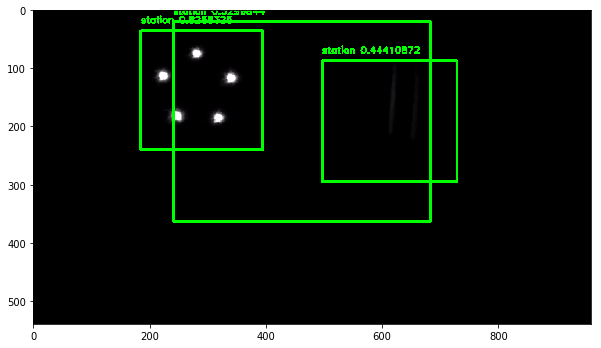

In [58]:
idx = 500
#image = cv2.imread('/tf/data/stream3_images/'+str(idx)+'.jpg')
image = cv2.imread('/tf/data/stream2/7214.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.1,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [55]:
# config_path= "yolo_mobilenetv7_v2.cfg"
# weights_path = "yolo_mobilenet_weights.hd5"
# with open(config_path,'rb') as f:
#     cfg = pickle.load(f)
#     model = model_from_json(cfg)
    

# with open(weights_path,'rb') as f:
#     weights = pickle.load(f)
#     model.set_weights(weights)

In [66]:
from keras.models import model_from_json

    
    
!pip install pascal-voc-writer
from pascal_voc_writer import Writer
import glob
for file in glob.glob('/tf/data/data/stream_training/*.jpg'):
    print(file)
    image = cv2.imread(file)
    file_name = os.path.basename(file)
    print(file_name)
    writer = Writer('/tf/data/stream_images_adj_final/third'+ file_name, image.shape[1], image.shape[0])
    image_path = '/tf/data/stream_images_adj_final/third'+file_name
    image_bbox_path = '/tf/data/stream_images_adj_final_bbox/third'+file_name
    image_ann_path = '/tf/data/stream_images_adj_final_annotations/third'+file_name.split('.')[0]+'.xml'
    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
    
    #plt.figure(figsize=(10,10))
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0],obj_threshold=0.5,nms_threshold=0.3,anchors=ANCHORS,nb_class=CLASS)
    max_score = -1
    saved_box = None
    for bbox in boxes:
        if bbox.get_score()>max_score:
            saved_box = bbox
    if saved_box!=None:
        box = saved_box
        image_h, image_w, _ = image.shape
        xmin = int(box.xmin*image_w)
        ymin = int(box.ymin*image_h)
        xmax = int(box.xmax*image_w)
        ymax = int(box.ymax*image_h)
        writer.addObject('station', xmin, ymin, xmax, ymax)
        writer.save(image_ann_path)
        print(image_ann_path)
        pt1 = (int(xmin),int(ymin))
        pt2 = (int(xmax),int(ymax))
        image_copy = np.copy(image)
        cv2.rectangle(image_copy,pt1,pt2,(0,255,255),thickness=2)    
    
    cv2.imwrite(image_path,image)
    cv2.imwrite(image_bbox_path,image_copy)

/tf/data/data/stream_training/2921.jpg
2921.jpg
/tf/data/data/stream_training/3178.jpg
3178.jpg
/tf/data/stream_images_adj_final_annotations/third3178.xml
/tf/data/data/stream_training/1792.jpg
1792.jpg
/tf/data/stream_images_adj_final_annotations/third1792.xml
/tf/data/data/stream_training/3441.jpg
3441.jpg
/tf/data/stream_images_adj_final_annotations/third3441.xml
/tf/data/data/stream_training/1428.jpg
1428.jpg
/tf/data/stream_images_adj_final_annotations/third1428.xml
/tf/data/data/stream_training/2270.jpg
2270.jpg
/tf/data/stream_images_adj_final_annotations/third2270.xml
/tf/data/data/stream_training/3231.jpg
3231.jpg
/tf/data/data/stream_training/2665.jpg
2665.jpg
/tf/data/data/stream_training/2581.jpg
2581.jpg
/tf/data/data/stream_training/2121.jpg
2121.jpg
/tf/data/stream_images_adj_final_annotations/third2121.xml
/tf/data/data/stream_training/3644.jpg
3644.jpg
/tf/data/data/stream_training/1816.jpg
1816.jpg
/tf/data/stream_images_adj_final_annotations/third1816.xml
/tf/data/da

/tf/data/data/stream_training/2543.jpg
2543.jpg
/tf/data/data/stream_training/1461.jpg
1461.jpg
/tf/data/stream_images_adj_final_annotations/third1461.xml
/tf/data/data/stream_training/1508.jpg
1508.jpg
/tf/data/stream_images_adj_final_annotations/third1508.xml
/tf/data/data/stream_training/2427.jpg
2427.jpg
/tf/data/stream_images_adj_final_annotations/third2427.xml
/tf/data/data/stream_training/3862.jpg
3862.jpg
/tf/data/stream_images_adj_final_annotations/third3862.xml
/tf/data/data/stream_training/2073.jpg
2073.jpg
/tf/data/stream_images_adj_final_annotations/third2073.xml
/tf/data/data/stream_training/3889.jpg
3889.jpg
/tf/data/data/stream_training/3002.jpg
3002.jpg
/tf/data/stream_images_adj_final_annotations/third3002.xml
/tf/data/data/stream_training/3125.jpg
3125.jpg
/tf/data/stream_images_adj_final_annotations/third3125.xml
/tf/data/data/stream_training/3135.jpg
3135.jpg
/tf/data/stream_images_adj_final_annotations/third3135.xml
/tf/data/data/stream_training/3614.jpg
3614.jpg


/tf/data/stream_images_adj_final_annotations/third1901.xml
/tf/data/data/stream_training/1827.jpg
1827.jpg
/tf/data/stream_images_adj_final_annotations/third1827.xml
/tf/data/data/stream_training/3164.jpg
3164.jpg
/tf/data/data/stream_training/2106.jpg
2106.jpg
/tf/data/data/stream_training/2302.jpg
2302.jpg
/tf/data/stream_images_adj_final_annotations/third2302.xml
/tf/data/data/stream_training/2019.jpg
2019.jpg
/tf/data/data/stream_training/3414.jpg
3414.jpg
/tf/data/stream_images_adj_final_annotations/third3414.xml
/tf/data/data/stream_training/1516.jpg
1516.jpg
/tf/data/stream_images_adj_final_annotations/third1516.xml
/tf/data/data/stream_training/1805.jpg
1805.jpg
/tf/data/stream_images_adj_final_annotations/third1805.xml
/tf/data/data/stream_training/3971.jpg
3971.jpg
/tf/data/stream_images_adj_final_annotations/third3971.xml
/tf/data/data/stream_training/1883.jpg
1883.jpg
/tf/data/stream_images_adj_final_annotations/third1883.xml
/tf/data/data/stream_training/1345.jpg
1345.jpg


/tf/data/data/stream_training/1707.jpg
1707.jpg
/tf/data/stream_images_adj_final_annotations/third1707.xml
/tf/data/data/stream_training/3100.jpg
3100.jpg
/tf/data/stream_images_adj_final_annotations/third3100.xml
/tf/data/data/stream_training/1511.jpg
1511.jpg
/tf/data/stream_images_adj_final_annotations/third1511.xml
/tf/data/data/stream_training/1988.jpg
1988.jpg
/tf/data/stream_images_adj_final_annotations/third1988.xml
/tf/data/data/stream_training/3846.jpg
3846.jpg
/tf/data/stream_images_adj_final_annotations/third3846.xml
/tf/data/data/stream_training/3356.jpg
3356.jpg
/tf/data/data/stream_training/1914.jpg
1914.jpg
/tf/data/stream_images_adj_final_annotations/third1914.xml
/tf/data/data/stream_training/1980.jpg
1980.jpg
/tf/data/stream_images_adj_final_annotations/third1980.xml
/tf/data/data/stream_training/1548.jpg
1548.jpg
/tf/data/data/stream_training/2598.jpg
2598.jpg
/tf/data/data/stream_training/2476.jpg
2476.jpg
/tf/data/stream_images_adj_final_annotations/third2476.xml


/tf/data/data/stream_training/1889.jpg
1889.jpg
/tf/data/stream_images_adj_final_annotations/third1889.xml
/tf/data/data/stream_training/2268.jpg
2268.jpg
/tf/data/stream_images_adj_final_annotations/third2268.xml
/tf/data/data/stream_training/2325.jpg
2325.jpg
/tf/data/data/stream_training/3064.jpg
3064.jpg
/tf/data/stream_images_adj_final_annotations/third3064.xml
/tf/data/data/stream_training/1602.jpg
1602.jpg
/tf/data/stream_images_adj_final_annotations/third1602.xml
/tf/data/data/stream_training/3570.jpg
3570.jpg
/tf/data/data/stream_training/3482.jpg
3482.jpg
/tf/data/stream_images_adj_final_annotations/third3482.xml
/tf/data/data/stream_training/3172.jpg
3172.jpg
/tf/data/data/stream_training/1813.jpg
1813.jpg
/tf/data/stream_images_adj_final_annotations/third1813.xml
/tf/data/data/stream_training/2569.jpg
2569.jpg
/tf/data/data/stream_training/2711.jpg
2711.jpg
/tf/data/data/stream_training/1391.jpg
1391.jpg
/tf/data/data/stream_training/1577.jpg
1577.jpg
/tf/data/stream_images

/tf/data/stream_images_adj_final_annotations/third2409.xml
/tf/data/data/stream_training/3227.jpg
3227.jpg
/tf/data/data/stream_training/1637.jpg
1637.jpg
/tf/data/stream_images_adj_final_annotations/third1637.xml
/tf/data/data/stream_training/1793.jpg
1793.jpg
/tf/data/stream_images_adj_final_annotations/third1793.xml
/tf/data/data/stream_training/3783.jpg
3783.jpg
/tf/data/stream_images_adj_final_annotations/third3783.xml
/tf/data/data/stream_training/2524.jpg
2524.jpg
/tf/data/stream_images_adj_final_annotations/third2524.xml
/tf/data/data/stream_training/2453.jpg
2453.jpg
/tf/data/stream_images_adj_final_annotations/third2453.xml
/tf/data/data/stream_training/2792.jpg
2792.jpg
/tf/data/stream_images_adj_final_annotations/third2792.xml
/tf/data/data/stream_training/3195.jpg
3195.jpg
/tf/data/stream_images_adj_final_annotations/third3195.xml
/tf/data/data/stream_training/1379.jpg
1379.jpg
/tf/data/stream_images_adj_final_annotations/third1379.xml
/tf/data/data/stream_training/3939.jp

/tf/data/data/stream_training/3295.jpg
3295.jpg
/tf/data/data/stream_training/3063.jpg
3063.jpg
/tf/data/stream_images_adj_final_annotations/third3063.xml
/tf/data/data/stream_training/2492.jpg
2492.jpg
/tf/data/stream_images_adj_final_annotations/third2492.xml
/tf/data/data/stream_training/2804.jpg
2804.jpg
/tf/data/stream_images_adj_final_annotations/third2804.xml
/tf/data/data/stream_training/2346.jpg
2346.jpg
/tf/data/stream_images_adj_final_annotations/third2346.xml
/tf/data/data/stream_training/2098.jpg
2098.jpg
/tf/data/data/stream_training/1667.jpg
1667.jpg
/tf/data/stream_images_adj_final_annotations/third1667.xml
/tf/data/data/stream_training/1658.jpg
1658.jpg
/tf/data/stream_images_adj_final_annotations/third1658.xml
/tf/data/data/stream_training/2209.jpg
2209.jpg
/tf/data/stream_images_adj_final_annotations/third2209.xml
/tf/data/data/stream_training/1572.jpg
1572.jpg
/tf/data/stream_images_adj_final_annotations/third1572.xml
/tf/data/data/stream_training/3354.jpg
3354.jpg


/tf/data/stream_images_adj_final_annotations/third2995.xml
/tf/data/data/stream_training/3621.jpg
3621.jpg
/tf/data/data/stream_training/2067.jpg
2067.jpg
/tf/data/stream_images_adj_final_annotations/third2067.xml
/tf/data/data/stream_training/2214.jpg
2214.jpg
/tf/data/stream_images_adj_final_annotations/third2214.xml
/tf/data/data/stream_training/3586.jpg
3586.jpg
/tf/data/data/stream_training/1932.jpg
1932.jpg
/tf/data/stream_images_adj_final_annotations/third1932.xml
/tf/data/data/stream_training/2295.jpg
2295.jpg
/tf/data/stream_images_adj_final_annotations/third2295.xml
/tf/data/data/stream_training/3369.jpg
3369.jpg
/tf/data/stream_images_adj_final_annotations/third3369.xml
/tf/data/data/stream_training/1359.jpg
1359.jpg
/tf/data/stream_images_adj_final_annotations/third1359.xml
/tf/data/data/stream_training/1452.jpg
1452.jpg
/tf/data/stream_images_adj_final_annotations/third1452.xml
/tf/data/data/stream_training/1899.jpg
1899.jpg
/tf/data/stream_images_adj_final_annotations/thi

1499.jpg
/tf/data/stream_images_adj_final_annotations/third1499.xml
/tf/data/data/stream_training/2431.jpg
2431.jpg
/tf/data/stream_images_adj_final_annotations/third2431.xml
/tf/data/data/stream_training/3888.jpg
3888.jpg
/tf/data/stream_images_adj_final_annotations/third3888.xml
/tf/data/data/stream_training/2199.jpg
2199.jpg
/tf/data/stream_images_adj_final_annotations/third2199.xml
/tf/data/data/stream_training/1845.jpg
1845.jpg
/tf/data/stream_images_adj_final_annotations/third1845.xml
/tf/data/data/stream_training/3970.jpg
3970.jpg
/tf/data/stream_images_adj_final_annotations/third3970.xml
/tf/data/data/stream_training/3300.jpg
3300.jpg
/tf/data/data/stream_training/1430.jpg
1430.jpg
/tf/data/data/stream_training/1850.jpg
1850.jpg
/tf/data/stream_images_adj_final_annotations/third1850.xml
/tf/data/data/stream_training/3026.jpg
3026.jpg
/tf/data/stream_images_adj_final_annotations/third3026.xml
/tf/data/data/stream_training/1807.jpg
1807.jpg
/tf/data/stream_images_adj_final_annota

/tf/data/stream_images_adj_final_annotations/third1464.xml
/tf/data/data/stream_training/1606.jpg
1606.jpg
/tf/data/stream_images_adj_final_annotations/third1606.xml
/tf/data/data/stream_training/2859.jpg
2859.jpg
/tf/data/stream_images_adj_final_annotations/third2859.xml
/tf/data/data/stream_training/1854.jpg
1854.jpg
/tf/data/stream_images_adj_final_annotations/third1854.xml
/tf/data/data/stream_training/3517.jpg
3517.jpg
/tf/data/stream_images_adj_final_annotations/third3517.xml
/tf/data/data/stream_training/3575.jpg
3575.jpg
/tf/data/data/stream_training/3432.jpg
3432.jpg
/tf/data/stream_images_adj_final_annotations/third3432.xml
/tf/data/data/stream_training/3031.jpg
3031.jpg
/tf/data/stream_images_adj_final_annotations/third3031.xml
/tf/data/data/stream_training/1934.jpg
1934.jpg
/tf/data/stream_images_adj_final_annotations/third1934.xml
/tf/data/data/stream_training/3378.jpg
3378.jpg
/tf/data/stream_images_adj_final_annotations/third3378.xml
/tf/data/data/stream_training/1334.jp

/tf/data/stream_images_adj_final_annotations/third2383.xml
/tf/data/data/stream_training/1600.jpg
1600.jpg
/tf/data/stream_images_adj_final_annotations/third1600.xml
/tf/data/data/stream_training/1896.jpg
1896.jpg
/tf/data/stream_images_adj_final_annotations/third1896.xml
/tf/data/data/stream_training/2502.jpg
2502.jpg
/tf/data/stream_images_adj_final_annotations/third2502.xml
/tf/data/data/stream_training/1450.jpg
1450.jpg
/tf/data/stream_images_adj_final_annotations/third1450.xml
/tf/data/data/stream_training/2687.jpg
2687.jpg
/tf/data/stream_images_adj_final_annotations/third2687.xml
/tf/data/data/stream_training/3183.jpg
3183.jpg
/tf/data/stream_images_adj_final_annotations/third3183.xml
/tf/data/data/stream_training/1320.jpg
1320.jpg
/tf/data/stream_images_adj_final_annotations/third1320.xml
/tf/data/data/stream_training/2545.jpg
2545.jpg
/tf/data/data/stream_training/2554.jpg
2554.jpg
/tf/data/stream_images_adj_final_annotations/third2554.xml
/tf/data/data/stream_training/3737.jp

/tf/data/stream_images_adj_final_annotations/third3089.xml
/tf/data/data/stream_training/3980.jpg
3980.jpg
/tf/data/stream_images_adj_final_annotations/third3980.xml
/tf/data/data/stream_training/3811.jpg
3811.jpg
/tf/data/stream_images_adj_final_annotations/third3811.xml
/tf/data/data/stream_training/1323.jpg
1323.jpg
/tf/data/stream_images_adj_final_annotations/third1323.xml
/tf/data/data/stream_training/2333.jpg
2333.jpg
/tf/data/stream_images_adj_final_annotations/third2333.xml
/tf/data/data/stream_training/3845.jpg
3845.jpg
/tf/data/stream_images_adj_final_annotations/third3845.xml
/tf/data/data/stream_training/2477.jpg
2477.jpg
/tf/data/stream_images_adj_final_annotations/third2477.xml
/tf/data/data/stream_training/2917.jpg
2917.jpg
/tf/data/stream_images_adj_final_annotations/third2917.xml
/tf/data/data/stream_training/1677.jpg
1677.jpg
/tf/data/stream_images_adj_final_annotations/third1677.xml
/tf/data/data/stream_training/3912.jpg
3912.jpg
/tf/data/stream_images_adj_final_anno

/tf/data/stream_images_adj_final_annotations/third2090.xml
/tf/data/data/stream_training/2458.jpg
2458.jpg
/tf/data/stream_images_adj_final_annotations/third2458.xml
/tf/data/data/stream_training/2650.jpg
2650.jpg
/tf/data/data/stream_training/3191.jpg
3191.jpg
/tf/data/stream_images_adj_final_annotations/third3191.xml
/tf/data/data/stream_training/1312.jpg
1312.jpg
/tf/data/data/stream_training/2505.jpg
2505.jpg
/tf/data/stream_images_adj_final_annotations/third2505.xml
/tf/data/data/stream_training/1659.jpg
1659.jpg
/tf/data/stream_images_adj_final_annotations/third1659.xml
/tf/data/data/stream_training/3243.jpg
3243.jpg
/tf/data/data/stream_training/2800.jpg
2800.jpg
/tf/data/stream_images_adj_final_annotations/third2800.xml
/tf/data/data/stream_training/3056.jpg
3056.jpg
/tf/data/stream_images_adj_final_annotations/third3056.xml
/tf/data/data/stream_training/2942.jpg
2942.jpg
/tf/data/stream_images_adj_final_annotations/third2942.xml
/tf/data/data/stream_training/2882.jpg
2882.jpg


/tf/data/stream_images_adj_final_annotations/third2263.xml
/tf/data/data/stream_training/2082.jpg
2082.jpg
/tf/data/stream_images_adj_final_annotations/third2082.xml
/tf/data/data/stream_training/3901.jpg
3901.jpg
/tf/data/stream_images_adj_final_annotations/third3901.xml
/tf/data/data/stream_training/2914.jpg
2914.jpg
/tf/data/data/stream_training/2777.jpg
2777.jpg
/tf/data/data/stream_training/2981.jpg
2981.jpg
/tf/data/stream_images_adj_final_annotations/third2981.xml
/tf/data/data/stream_training/1965.jpg
1965.jpg
/tf/data/stream_images_adj_final_annotations/third1965.xml
/tf/data/data/stream_training/3603.jpg
3603.jpg
/tf/data/data/stream_training/3108.jpg
3108.jpg
/tf/data/stream_images_adj_final_annotations/third3108.xml
/tf/data/data/stream_training/1638.jpg
1638.jpg
/tf/data/stream_images_adj_final_annotations/third1638.xml
/tf/data/data/stream_training/3623.jpg
3623.jpg
/tf/data/data/stream_training/2179.jpg
2179.jpg
/tf/data/stream_images_adj_final_annotations/third2179.xml


/tf/data/stream_images_adj_final_annotations/third1994.xml
/tf/data/data/stream_training/1937.jpg
1937.jpg
/tf/data/stream_images_adj_final_annotations/third1937.xml
/tf/data/data/stream_training/3631.jpg
3631.jpg
/tf/data/data/stream_training/3676.jpg
3676.jpg
/tf/data/data/stream_training/1819.jpg
1819.jpg
/tf/data/stream_images_adj_final_annotations/third1819.xml
/tf/data/data/stream_training/2300.jpg
2300.jpg
/tf/data/stream_images_adj_final_annotations/third2300.xml
/tf/data/data/stream_training/2341.jpg
2341.jpg
/tf/data/stream_images_adj_final_annotations/third2341.xml
/tf/data/data/stream_training/1715.jpg
1715.jpg
/tf/data/stream_images_adj_final_annotations/third1715.xml
/tf/data/data/stream_training/1700.jpg
1700.jpg
/tf/data/stream_images_adj_final_annotations/third1700.xml
/tf/data/data/stream_training/2066.jpg
2066.jpg
/tf/data/stream_images_adj_final_annotations/third2066.xml
/tf/data/data/stream_training/2866.jpg
2866.jpg
/tf/data/data/stream_training/3288.jpg
3288.jpg


/tf/data/stream_images_adj_final_annotations/third2560.xml
/tf/data/data/stream_training/3168.jpg
3168.jpg
/tf/data/data/stream_training/1979.jpg
1979.jpg
/tf/data/stream_images_adj_final_annotations/third1979.xml
/tf/data/data/stream_training/3297.jpg
3297.jpg
/tf/data/data/stream_training/2998.jpg
2998.jpg
/tf/data/stream_images_adj_final_annotations/third2998.xml
/tf/data/data/stream_training/2586.jpg
2586.jpg
/tf/data/stream_images_adj_final_annotations/third2586.xml
/tf/data/data/stream_training/2384.jpg
2384.jpg
/tf/data/stream_images_adj_final_annotations/third2384.xml
/tf/data/data/stream_training/2735.jpg
2735.jpg
/tf/data/stream_images_adj_final_annotations/third2735.xml
/tf/data/data/stream_training/2559.jpg
2559.jpg
/tf/data/stream_images_adj_final_annotations/third2559.xml
/tf/data/data/stream_training/2886.jpg
2886.jpg
/tf/data/stream_images_adj_final_annotations/third2886.xml
/tf/data/data/stream_training/1704.jpg
1704.jpg
/tf/data/stream_images_adj_final_annotations/thi

/tf/data/data/stream_training/2048.jpg
2048.jpg
/tf/data/stream_images_adj_final_annotations/third2048.xml
/tf/data/data/stream_training/2184.jpg
2184.jpg
/tf/data/stream_images_adj_final_annotations/third2184.xml
/tf/data/data/stream_training/1446.jpg
1446.jpg
/tf/data/stream_images_adj_final_annotations/third1446.xml
/tf/data/data/stream_training/2482.jpg
2482.jpg
/tf/data/stream_images_adj_final_annotations/third2482.xml
/tf/data/data/stream_training/3550.jpg
3550.jpg
/tf/data/stream_images_adj_final_annotations/third3550.xml
/tf/data/data/stream_training/1623.jpg
1623.jpg
/tf/data/stream_images_adj_final_annotations/third1623.xml
/tf/data/data/stream_training/1523.jpg
1523.jpg
/tf/data/data/stream_training/2803.jpg
2803.jpg
/tf/data/stream_images_adj_final_annotations/third2803.xml
/tf/data/data/stream_training/1369.jpg
1369.jpg
/tf/data/data/stream_training/2366.jpg
2366.jpg
/tf/data/stream_images_adj_final_annotations/third2366.xml
/tf/data/data/stream_training/2888.jpg
2888.jpg


/tf/data/stream_images_adj_final_annotations/third3731.xml
/tf/data/data/stream_training/3038.jpg
3038.jpg
/tf/data/stream_images_adj_final_annotations/third3038.xml
/tf/data/data/stream_training/2725.jpg
2725.jpg
/tf/data/stream_images_adj_final_annotations/third2725.xml
/tf/data/data/stream_training/3922.jpg
3922.jpg
/tf/data/stream_images_adj_final_annotations/third3922.xml
/tf/data/data/stream_training/2284.jpg
2284.jpg
/tf/data/stream_images_adj_final_annotations/third2284.xml
/tf/data/data/stream_training/1872.jpg
1872.jpg
/tf/data/stream_images_adj_final_annotations/third1872.xml
/tf/data/data/stream_training/2089.jpg
2089.jpg
/tf/data/stream_images_adj_final_annotations/third2089.xml
/tf/data/data/stream_training/2879.jpg
2879.jpg
/tf/data/stream_images_adj_final_annotations/third2879.xml
/tf/data/data/stream_training/1412.jpg
1412.jpg
/tf/data/data/stream_training/2349.jpg
2349.jpg
/tf/data/stream_images_adj_final_annotations/third2349.xml
/tf/data/data/stream_training/2377.jp

/tf/data/stream_images_adj_final_annotations/third1773.xml
/tf/data/data/stream_training/2265.jpg
2265.jpg
/tf/data/stream_images_adj_final_annotations/third2265.xml
/tf/data/data/stream_training/2607.jpg
2607.jpg
/tf/data/data/stream_training/3926.jpg
3926.jpg
/tf/data/stream_images_adj_final_annotations/third3926.xml
/tf/data/data/stream_training/3067.jpg
3067.jpg
/tf/data/stream_images_adj_final_annotations/third3067.xml
/tf/data/data/stream_training/2535.jpg
2535.jpg
/tf/data/data/stream_training/3694.jpg
3694.jpg
/tf/data/stream_images_adj_final_annotations/third3694.xml
/tf/data/data/stream_training/2452.jpg
2452.jpg
/tf/data/stream_images_adj_final_annotations/third2452.xml
/tf/data/data/stream_training/2723.jpg
2723.jpg
/tf/data/data/stream_training/1779.jpg
1779.jpg
/tf/data/stream_images_adj_final_annotations/third1779.xml
/tf/data/data/stream_training/3062.jpg
3062.jpg
/tf/data/stream_images_adj_final_annotations/third3062.xml
/tf/data/data/stream_training/2529.jpg
2529.jpg


/tf/data/data/stream_training/2045.jpg
2045.jpg
/tf/data/stream_images_adj_final_annotations/third2045.xml
/tf/data/data/stream_training/3725.jpg
3725.jpg
/tf/data/stream_images_adj_final_annotations/third3725.xml
/tf/data/data/stream_training/1298.jpg
1298.jpg
/tf/data/stream_images_adj_final_annotations/third1298.xml
/tf/data/data/stream_training/1992.jpg
1992.jpg
/tf/data/stream_images_adj_final_annotations/third1992.xml
/tf/data/data/stream_training/2116.jpg
2116.jpg
/tf/data/stream_images_adj_final_annotations/third2116.xml
/tf/data/data/stream_training/3514.jpg
3514.jpg
/tf/data/stream_images_adj_final_annotations/third3514.xml
/tf/data/data/stream_training/3152.jpg
3152.jpg
/tf/data/stream_images_adj_final_annotations/third3152.xml
/tf/data/data/stream_training/1892.jpg
1892.jpg
/tf/data/stream_images_adj_final_annotations/third1892.xml
/tf/data/data/stream_training/3741.jpg
3741.jpg
/tf/data/stream_images_adj_final_annotations/third3741.xml
/tf/data/data/stream_training/2368.jp

/tf/data/data/stream_training/2558.jpg
2558.jpg
/tf/data/data/stream_training/2739.jpg
2739.jpg
/tf/data/stream_images_adj_final_annotations/third2739.xml
/tf/data/data/stream_training/1297.jpg
1297.jpg
/tf/data/stream_images_adj_final_annotations/third1297.xml
/tf/data/data/stream_training/3840.jpg
3840.jpg
/tf/data/stream_images_adj_final_annotations/third3840.xml
/tf/data/data/stream_training/3706.jpg
3706.jpg
/tf/data/stream_images_adj_final_annotations/third3706.xml
/tf/data/data/stream_training/3903.jpg
3903.jpg
/tf/data/stream_images_adj_final_annotations/third3903.xml
/tf/data/data/stream_training/3081.jpg
3081.jpg
/tf/data/stream_images_adj_final_annotations/third3081.xml
/tf/data/data/stream_training/2498.jpg
2498.jpg
/tf/data/stream_images_adj_final_annotations/third2498.xml
/tf/data/data/stream_training/2857.jpg
2857.jpg
/tf/data/stream_images_adj_final_annotations/third2857.xml
/tf/data/data/stream_training/2061.jpg
2061.jpg
/tf/data/stream_images_adj_final_annotations/thi

3933.jpg
/tf/data/stream_images_adj_final_annotations/third3933.xml
/tf/data/data/stream_training/1824.jpg
1824.jpg
/tf/data/stream_images_adj_final_annotations/third1824.xml
/tf/data/data/stream_training/1605.jpg
1605.jpg
/tf/data/stream_images_adj_final_annotations/third1605.xml
/tf/data/data/stream_training/1562.jpg
1562.jpg
/tf/data/data/stream_training/3553.jpg
3553.jpg
/tf/data/stream_images_adj_final_annotations/third3553.xml
/tf/data/data/stream_training/2236.jpg
2236.jpg
/tf/data/stream_images_adj_final_annotations/third2236.xml
/tf/data/data/stream_training/1962.jpg
1962.jpg
/tf/data/stream_images_adj_final_annotations/third1962.xml
/tf/data/data/stream_training/2080.jpg
2080.jpg
/tf/data/stream_images_adj_final_annotations/third2080.xml
/tf/data/data/stream_training/2227.jpg
2227.jpg
/tf/data/stream_images_adj_final_annotations/third2227.xml
/tf/data/data/stream_training/3407.jpg
3407.jpg
/tf/data/stream_images_adj_final_annotations/third3407.xml
/tf/data/data/stream_trainin

/tf/data/stream_images_adj_final_annotations/third2212.xml
/tf/data/data/stream_training/2916.jpg
2916.jpg
/tf/data/stream_images_adj_final_annotations/third2916.xml
/tf/data/data/stream_training/1759.jpg
1759.jpg
/tf/data/stream_images_adj_final_annotations/third1759.xml
/tf/data/data/stream_training/3555.jpg
3555.jpg
/tf/data/stream_images_adj_final_annotations/third3555.xml
/tf/data/data/stream_training/3304.jpg
3304.jpg
/tf/data/data/stream_training/1501.jpg
1501.jpg
/tf/data/stream_images_adj_final_annotations/third1501.xml
/tf/data/data/stream_training/3424.jpg
3424.jpg
/tf/data/stream_images_adj_final_annotations/third3424.xml
/tf/data/data/stream_training/3750.jpg
3750.jpg
/tf/data/stream_images_adj_final_annotations/third3750.xml
/tf/data/data/stream_training/1682.jpg
1682.jpg
/tf/data/stream_images_adj_final_annotations/third1682.xml
/tf/data/data/stream_training/2107.jpg
2107.jpg
/tf/data/data/stream_training/3106.jpg
3106.jpg
/tf/data/stream_images_adj_final_annotations/thi

/tf/data/data/stream_training/3618.jpg
3618.jpg
/tf/data/data/stream_training/2903.jpg
2903.jpg
/tf/data/stream_images_adj_final_annotations/third2903.xml
/tf/data/data/stream_training/2515.jpg
2515.jpg
/tf/data/data/stream_training/1926.jpg
1926.jpg
/tf/data/stream_images_adj_final_annotations/third1926.xml
/tf/data/data/stream_training/1782.jpg
1782.jpg
/tf/data/stream_images_adj_final_annotations/third1782.xml
/tf/data/data/stream_training/3205.jpg
3205.jpg
/tf/data/stream_images_adj_final_annotations/third3205.xml
/tf/data/data/stream_training/3273.jpg
3273.jpg
/tf/data/data/stream_training/1544.jpg
1544.jpg
/tf/data/stream_images_adj_final_annotations/third1544.xml
/tf/data/data/stream_training/2442.jpg
2442.jpg
/tf/data/stream_images_adj_final_annotations/third2442.xml
/tf/data/data/stream_training/3956.jpg
3956.jpg
/tf/data/stream_images_adj_final_annotations/third3956.xml
/tf/data/data/stream_training/2091.jpg
2091.jpg
/tf/data/stream_images_adj_final_annotations/third2091.xml


/tf/data/stream_images_adj_final_annotations/third3761.xml
/tf/data/data/stream_training/3610.jpg
3610.jpg
/tf/data/data/stream_training/3598.jpg
3598.jpg
/tf/data/data/stream_training/2266.jpg
2266.jpg
/tf/data/stream_images_adj_final_annotations/third2266.xml
/tf/data/data/stream_training/1595.jpg
1595.jpg
/tf/data/stream_images_adj_final_annotations/third1595.xml
/tf/data/data/stream_training/2241.jpg
2241.jpg
/tf/data/stream_images_adj_final_annotations/third2241.xml
/tf/data/data/stream_training/2495.jpg
2495.jpg
/tf/data/stream_images_adj_final_annotations/third2495.xml
/tf/data/data/stream_training/2639.jpg
2639.jpg
/tf/data/data/stream_training/1373.jpg
1373.jpg
/tf/data/stream_images_adj_final_annotations/third1373.xml
/tf/data/data/stream_training/1991.jpg
1991.jpg
/tf/data/stream_images_adj_final_annotations/third1991.xml
/tf/data/data/stream_training/1735.jpg
1735.jpg
/tf/data/stream_images_adj_final_annotations/third1735.xml
/tf/data/data/stream_training/3735.jpg
3735.jpg


/tf/data/data/stream_training/2191.jpg
2191.jpg
/tf/data/stream_images_adj_final_annotations/third2191.xml
/tf/data/data/stream_training/2684.jpg
2684.jpg
/tf/data/stream_images_adj_final_annotations/third2684.xml
/tf/data/data/stream_training/2669.jpg
2669.jpg
/tf/data/data/stream_training/1968.jpg
1968.jpg
/tf/data/stream_images_adj_final_annotations/third1968.xml
/tf/data/data/stream_training/1382.jpg
1382.jpg
/tf/data/stream_images_adj_final_annotations/third1382.xml
/tf/data/data/stream_training/3502.jpg
3502.jpg
/tf/data/stream_images_adj_final_annotations/third3502.xml
/tf/data/data/stream_training/1490.jpg
1490.jpg
/tf/data/stream_images_adj_final_annotations/third1490.xml
/tf/data/data/stream_training/3082.jpg
3082.jpg
/tf/data/stream_images_adj_final_annotations/third3082.xml
/tf/data/data/stream_training/3716.jpg
3716.jpg
/tf/data/stream_images_adj_final_annotations/third3716.xml
/tf/data/data/stream_training/2510.jpg
2510.jpg
/tf/data/stream_images_adj_final_annotations/thi

/tf/data/data/stream_training/3103.jpg
3103.jpg
/tf/data/stream_images_adj_final_annotations/third3103.xml
/tf/data/data/stream_training/1489.jpg
1489.jpg
/tf/data/stream_images_adj_final_annotations/third1489.xml
/tf/data/data/stream_training/1350.jpg
1350.jpg
/tf/data/stream_images_adj_final_annotations/third1350.xml
/tf/data/data/stream_training/2029.jpg
2029.jpg
/tf/data/stream_images_adj_final_annotations/third2029.xml
/tf/data/data/stream_training/1554.jpg
1554.jpg
/tf/data/stream_images_adj_final_annotations/third1554.xml
/tf/data/data/stream_training/1729.jpg
1729.jpg
/tf/data/stream_images_adj_final_annotations/third1729.xml
/tf/data/data/stream_training/2040.jpg
2040.jpg
/tf/data/stream_images_adj_final_annotations/third2040.xml
/tf/data/data/stream_training/1596.jpg
1596.jpg
/tf/data/stream_images_adj_final_annotations/third1596.xml
/tf/data/data/stream_training/2744.jpg
2744.jpg
/tf/data/stream_images_adj_final_annotations/third2744.xml
/tf/data/data/stream_training/2407.jp

/tf/data/data/stream_training/3348.jpg
3348.jpg
/tf/data/data/stream_training/2571.jpg
2571.jpg
/tf/data/data/stream_training/3364.jpg
3364.jpg
/tf/data/stream_images_adj_final_annotations/third3364.xml
/tf/data/data/stream_training/2699.jpg
2699.jpg
/tf/data/data/stream_training/2690.jpg
2690.jpg
/tf/data/stream_images_adj_final_annotations/third2690.xml
/tf/data/data/stream_training/2494.jpg
2494.jpg
/tf/data/stream_images_adj_final_annotations/third2494.xml
/tf/data/data/stream_training/3210.jpg
3210.jpg
/tf/data/data/stream_training/3765.jpg
3765.jpg
/tf/data/stream_images_adj_final_annotations/third3765.xml
/tf/data/data/stream_training/2232.jpg
2232.jpg
/tf/data/stream_images_adj_final_annotations/third2232.xml
/tf/data/data/stream_training/3969.jpg
3969.jpg
/tf/data/stream_images_adj_final_annotations/third3969.xml
/tf/data/data/stream_training/2989.jpg
2989.jpg
/tf/data/stream_images_adj_final_annotations/third2989.xml
/tf/data/data/stream_training/2234.jpg
2234.jpg
/tf/data/st

/tf/data/data/stream_training/2435.jpg
2435.jpg
/tf/data/stream_images_adj_final_annotations/third2435.xml
/tf/data/data/stream_training/3006.jpg
3006.jpg
/tf/data/stream_images_adj_final_annotations/third3006.xml
/tf/data/data/stream_training/1800.jpg
1800.jpg
/tf/data/stream_images_adj_final_annotations/third1800.xml
/tf/data/data/stream_training/3197.jpg
3197.jpg
/tf/data/stream_images_adj_final_annotations/third3197.xml
/tf/data/data/stream_training/3733.jpg
3733.jpg
/tf/data/stream_images_adj_final_annotations/third3733.xml
/tf/data/data/stream_training/3651.jpg
3651.jpg
/tf/data/data/stream_training/3806.jpg
3806.jpg
/tf/data/stream_images_adj_final_annotations/third3806.xml
/tf/data/data/stream_training/2226.jpg
2226.jpg
/tf/data/stream_images_adj_final_annotations/third2226.xml
/tf/data/data/stream_training/1989.jpg
1989.jpg
/tf/data/stream_images_adj_final_annotations/third1989.xml
/tf/data/data/stream_training/2364.jpg
2364.jpg
/tf/data/stream_images_adj_final_annotations/thi

/tf/data/stream_images_adj_final_annotations/third2450.xml
/tf/data/data/stream_training/2421.jpg
2421.jpg
/tf/data/stream_images_adj_final_annotations/third2421.xml
/tf/data/data/stream_training/2262.jpg
2262.jpg
/tf/data/stream_images_adj_final_annotations/third2262.xml
/tf/data/data/stream_training/1803.jpg
1803.jpg
/tf/data/stream_images_adj_final_annotations/third1803.xml
/tf/data/data/stream_training/2169.jpg
2169.jpg
/tf/data/stream_images_adj_final_annotations/third2169.xml
/tf/data/data/stream_training/3237.jpg
3237.jpg
/tf/data/data/stream_training/3256.jpg
3256.jpg
/tf/data/data/stream_training/3627.jpg
3627.jpg
/tf/data/data/stream_training/2980.jpg
2980.jpg
/tf/data/stream_images_adj_final_annotations/third2980.xml
/tf/data/data/stream_training/2350.jpg
2350.jpg
/tf/data/stream_images_adj_final_annotations/third2350.xml
/tf/data/data/stream_training/2189.jpg
2189.jpg
/tf/data/stream_images_adj_final_annotations/third2189.xml
/tf/data/data/stream_training/3028.jpg
3028.jpg


3871.jpg
/tf/data/stream_images_adj_final_annotations/third3871.xml
/tf/data/data/stream_training/1958.jpg
1958.jpg
/tf/data/stream_images_adj_final_annotations/third1958.xml


# Perform detection on video

In [70]:
model.load_weights("weights_coco_mobilenet1.h5")

dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

In [18]:
video_inp = '/tf/data/stream5_testing.mp4'
video_out = '/tf/data/stream5_predicted.mp4'

video_reader = cv2.VideoCapture(video_inp)

nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))

video_writer = cv2.VideoWriter(video_out,
                               cv2.VideoWriter_fourcc(*'XVID'), 
                               50.0, 
                               (frame_w, frame_h))

for i in tqdm(range(nb_frames)):
    ret, image = video_reader.read()
    
    input_image = cv2.resize(image, (224, 224))
    input_image = input_image / 255.
    input_image = input_image[:,:,::-1]
    input_image = np.expand_dims(input_image, 0)

    netout = model.predict([input_image, dummy_array])

    boxes = decode_netout(netout[0], 
                          obj_threshold=0.5,
                          nms_threshold=NMS_THRESHOLD,
                          anchors=ANCHORS, 
                          nb_class=CLASS)
    image = draw_boxes(image, boxes, labels=LABELS)

    video_writer.write(np.uint8(image))
    
video_reader.release()
video_writer.release()  


 43%|████▎     | 2306/5302 [00:32<00:42, 71.00it/s]


 86%|████████▌ | 4569/5302 [01:05<00:10, 67.94it/s]


100%|██████████| 5302/5302 [01:15<00:00, 69.88it/s]

In [168]:
a = boxes[0]

In [47]:
max_score = -1
saved_box = []
for bbox in boxes:
    if bbox.get_score()>max_score:
        saved_box = bbox

In [20]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 1, 1, 1, 50, 4) dtype=float32>]
[<tf.Tensor 'lambda_1/Identity:0' shape=(?, 7, 7, 5, 6) dtype=float32>]


In [20]:
K.set_learning_phase(0)  # all new operations will be in test mode from now on

config = model.to_json()
weights = model.get_weights()

import pickle
with open('yolo_mobilenetv2.cfg','wb') as f:
    pickle.dump(config,f)
with open('yolo_mobilenet_weightsv2.hd5','wb') as f:
    pickle.dump(weights,f)
#del model

# from keras.models import model_from_json
# new_model = model_from_json(config)
# new_model.set_weights(weights)

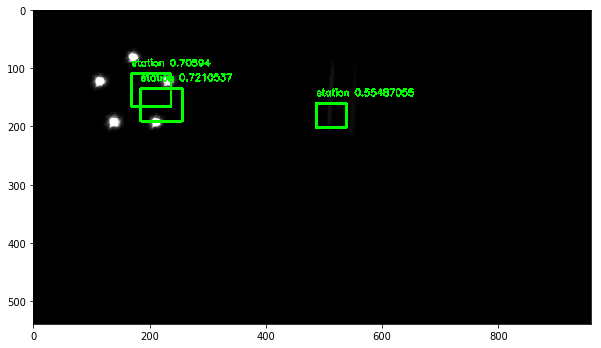

In [27]:
ANCHORS          = [0.1,0.1,0.7,0.7,2,2,5,5,9,9]
idx = 500
#image = cv2.imread('/tf/data/stream3_images/'+str(idx)+'.jpg')
image = cv2.imread('/tf/data/stream2/7200.jpg')
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (224, 224))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = model.predict([input_image, dummy_array])

boxes = decode_netout(netout[0], 
                      obj_threshold=0.5,
                      nms_threshold=0.3,
                      anchors=ANCHORS, 
                      nb_class=CLASS)
            
image = draw_boxes(image, boxes, labels=LABELS)

plt.imshow(image[:,:,::-1]); plt.show()

In [59]:
model.outputs

[<tf.Tensor 'lambda_2/Identity:0' shape=(?, 7, 7, 5, 6) dtype=float32>]

In [79]:
model.inputs

[<tf.Tensor 'input_3:0' shape=(?, 224, 224, 3) dtype=float32>,
 <tf.Tensor 'input_2_2:0' shape=(?, 1, 1, 1, 50, 4) dtype=float32>]